In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install laspy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 9.3 MB/s eta 0:00:00


In [4]:
import os
from glob import glob
from PIL import Image
import laspy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import spectral
import cv2
from skimage import io

In [5]:
base_dir = '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing'

rgb_list = sorted(glob(os.path.join(base_dir, 'RGB', '*.tif')))
las_list = sorted(glob(os.path.join(base_dir, 'LAS', '*.las'))) # LiDAR
hsi_list = sorted(glob(os.path.join(base_dir, 'HSI', '*.tif'))) # Hyperspectral
chm_list = sorted(glob(os.path.join(base_dir, 'CHM', '*.tif'))) # Canopy Height Model

In [7]:
import random
from random import sample

random.seed(0)
val_test = sample(rgb_list, 18)
val = val_test[:9]
test = val_test[9:]
train = [x for x in rgb_list if x not in val_test]

In [8]:
val

['/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/OSBS_12.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/OSBS_16.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_14.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_4.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/OSBS_27.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/OSBS_24.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/OSBS_14.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_44.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/OSBS_23.tif']

In [9]:
test

['/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_9.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/OSBS_35.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_34.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/OSBS_26.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_25.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_42.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/OSBS_32.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_20.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_39.tif']

In [10]:
train

['/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_1.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_10.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_11.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_12.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_13.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_15.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_16.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_17.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_18.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_19.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_2.tif',
 '/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_21.tif',
 '/content/drive/MyDrive/ift6759_trees/dat

In [11]:
len(val), len(test), len(train)

(9, 9, 67)

In [12]:
os.makedirs('/content/drive/MyDrive/ift6759_trees/data/interim/RemoteSensing/train/RGB', exist_ok=True)
os.makedirs('/content/drive/MyDrive/ift6759_trees/data/interim/RemoteSensing/val/RGB', exist_ok=True)
os.makedirs('/content/drive/MyDrive/ift6759_trees/data/interim/RemoteSensing/test/RGB', exist_ok=True)

In [14]:
len(glob(os.path.join('/content/drive/MyDrive/ift6759_trees/data/interim/RemoteSensing/train/CHM', '*.tif')))

67

In [ ]:
import shutil

dst = '/content/drive/MyDrive/ift6759_trees/data/interim/RemoteSensing/test/CHM'
for file in test:
  filename = os.path.basename(file)
  dst_name = os.path.join(dst, filename)
  shutil.copy2(file, dst_name)

In [ ]:
len(rgb_list), len(las_list), len(hsi_list), len(chm_list)

(85, 85, 85, 85)

In [26]:
!pip install rasterio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 24.5 MB/s eta 0:00:00


In [66]:
!pip install Fiona -q

<AxesSubplot:>

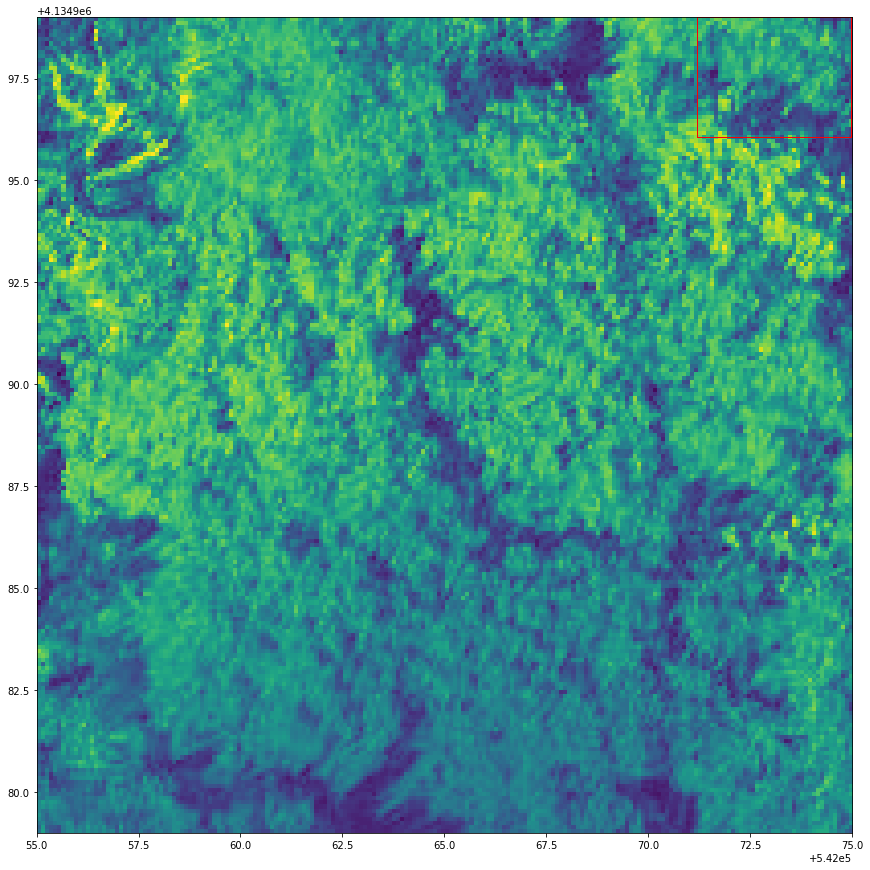

In [89]:
import geopandas
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot

fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(img, ax=ax)
test.plot(ax=ax, facecolor='none', edgecolor='red')

In [83]:
from rasterio.mask import mask

data = rgb_list[0]
mlbs_shapefile_path = '/content/drive/MyDrive/ift6759_trees/data/raw/ITC/train_MLBS.shp'
mlbs = geopandas.read_file(mlbs_shapefile_path)
out_image, out_transform = mask(img, mlbs.geometry[0], invert=False)

TypeError: ignored

In [88]:
test = mlbs[mlbs.id == 57]
test

,id,indvdID,geometry
0,57,MLBS01681,"POLYGON ((542071.187 4134996.073, 542071.187 4..."


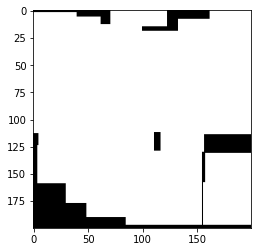

<AxesSubplot:>

In [84]:
show(out_image)

In [71]:
with rasterio.open(rgb_list[0]) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [75]:
plt.imshow(out_trans[1,:,:])

TypeError: ignored

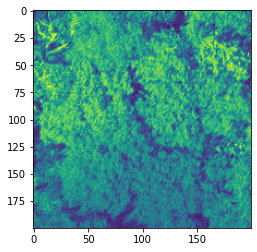

<AxesSubplot:>

In [ ]:
img = import geopandas
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot

fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(img, ax=ax)
test.plot(ax=ax, facecolor='none', edgecolor='red')import geopandas
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot

fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(img, ax=ax)
test.plot(ax=ax, facecolor='none', edgecolor='red')
show(img.read(1))

In [90]:
import ipywidgets as widgets
from ipywidgets import interact
import rasterio
from rasterio.plot import show

# https://towardsdatascience.com/reading-and-visualizing-geotiff-images-with-python-8dcca7a74510
@ interact(case_num=widgets.IntSlider(min=0, max=len(rgb_list)-1, step=1, value=0, description='Case #:'))
def display_rgb(case_num):
  print(rgb_list[case_num])
  img = rasterio.open(rgb_list[case_num])
  show(img.read(1)) # r
  show(img.read(2)) # g
  show(img.read(3)) # b

interactive(children=(IntSlider(value=0, description='Case #:', max=84), Output()), _dom_classes=('widget-inte…

In [24]:
df = pd.read_csv('/content/drive/MyDrive/ift6759_trees/data/interim/ITC/train.csv')
df

,minx,miny,maxx,maxy,id,indvdID,rsFile
0,542071.186834,4.134996e+06,542074.969940,4.134999e+06,57,MLBS01681,MLBS_1.tif
1,542055.000000,4.134994e+06,542058.995294,4.134999e+06,45,MLBS01679,MLBS_1.tif
2,542060.169555,4.134993e+06,542064.969398,4.134998e+06,49,MLBS01674,MLBS_1.tif
3,542057.701672,4.134992e+06,542061.088781,4.134995e+06,63,MLBS01678,MLBS_1.tif
4,542061.068128,4.134991e+06,542069.577248,4.134997e+06,50,MLBS01675,MLBS_1.tif
...,...,...,...,...,...,...,...
926,404886.400000,3.284465e+06,404893.920000,3.284466e+06,1037,OSBS00849,OSBS_9.tif
927,404899.070000,3.284468e+06,404906.000000,3.284476e+06,1034,OSBS00910,OSBS_9.tif
928,404891.840000,3.284471e+06,404899.850000,3.284478e+06,1032,OSBS07977,OSBS_9.tif
929,404891.740000,3.284467e+06,404899.050000,3.284472e+06,1035,OSBS00898,OSBS_9.tif


/content/drive/MyDrive/ift6759_trees/data/raw/RemoteSensing/RGB/MLBS_1.tif


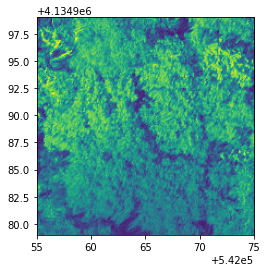

<AxesSubplot:>

In [27]:
import rasterio
from rasterio.plot import show

idx = 0
img = rasterio.open(rgb_list[idx])
print(rgb_list[idx])
show(img)

In [52]:
img.bounds

BoundingBox(left=542055.0, bottom=4134979.0, right=542075.0, top=4134999.0)

In [54]:
img.transform

Affine(0.1, 0.0, 542055.0,
       0.0, -0.1, 4134999.0)

In [55]:
img.transform * (img.width, img.height)

(542075.0, 4134979.0)

In [53]:
80.0 * 4.1349 ** 6, 97.5 * 4.1349 ** 6 # y

(399834.3042890992, 487298.0583523396)

In [50]:
55 * 5.42 ** 5, 75 * 5.42 ** 5 # x - longitude

(257252.214621776, 350798.47448424)

In [30]:
4.134996 ** 6

4998.625065697286

In [ ]:
# No. of Bands and Image resolution
img.count, img.height, img.width, 

(3, 200, 200)

In [ ]:
# Coordinate Reference System
img.crs

CRS.from_epsg(32617)

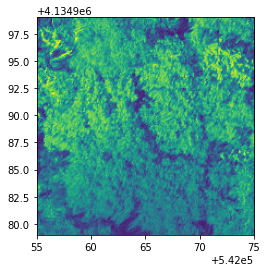

<AxesSubplot:>

In [ ]:
show(img) # x and y-axis scale values are longitude and latitude values

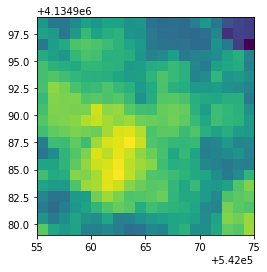

<AxesSubplot:>

In [ ]:
img_chm = rasterio.open(chm_list[0])
show(img_chm) 

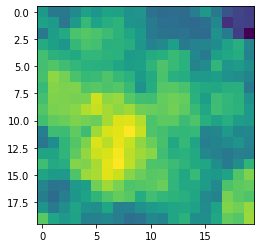

<AxesSubplot:>

In [ ]:
show(img_chm.read(1)) 

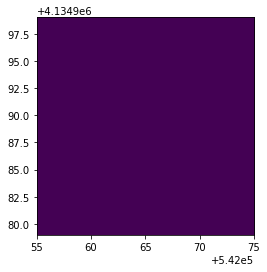

<AxesSubplot:>

In [ ]:
img_hsi = rasterio.open(hsi_list[0])
show(img_hsi)

In [ ]:
img_hsi.count, img_hsi.height, img_hsi.width

(369, 20, 20)

In [ ]:
img_chm.count, img_chm.height, img_chm.width

(1, 20, 20)

In [ ]:
img_chm.crs

CRS.from_epsg(32617)

In [ ]:
from spectral import *

img_hsi = open_image(hsi_list[0])

OSError: ignored

In [35]:
!pip install geopandas -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 76.7 MB/s eta 0:00:00


In [36]:
import geopandas
# https://stackoverflow.com/questions/60617819/how-to-read-shapefile-in-geopandas-when-having-dbf-prj-shp-and-shx-files

mlbs_shapefile_path = '/content/drive/MyDrive/ift6759_trees/data/raw/ITC/train_MLBS.shp'
osbs_shapefile_path = '/content/drive/MyDrive/ift6759_trees/data/raw/ITC/train_OSBS.shp'

mlbs = geopandas.read_file(mlbs_shapefile_path)
osbs = geopandas.read_file(osbs_shapefile_path)

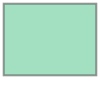

In [80]:
mlbs.geometry[0]

In [64]:
osbs.crs

<Derived Projected CRS: EPSG:32617>
Name: WGS 84 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°W and 78°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Ecuador - north of equator. Canada - Nunavut; Ontario; Quebec. Cayman Islands. Colombia. Costa Rica. Cuba. Jamaica. Nicaragua. Panama. United States (USA).
- bounds: (-84.0, 0.0, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [37]:
mlbs

,id,indvdID,geometry
0,57,MLBS01681,"POLYGON ((542071.187 4134996.073, 542071.187 4..."
1,45,MLBS01679,"POLYGON ((542055.000 4134998.793, 542058.995 4..."
2,49,MLBS01674,"POLYGON ((542060.170 4134993.382, 542060.170 4..."
3,63,MLBS01678,"POLYGON ((542057.702 4134991.627, 542057.702 4..."
4,50,MLBS01675,"POLYGON ((542061.068 4134991.193, 542061.068 4..."
...,...,...,...
703,89,MLBS01541,"POLYGON ((541876.000 4135859.653, 541882.697 4..."
704,84,MLBS01546,"POLYGON ((541887.842 4135850.434, 541887.842 4..."
705,86,MLBS01545,"POLYGON ((541879.662 4135850.434, 541879.662 4..."
706,90,MLBS01544,"POLYGON ((541878.045 4135858.489, 541878.045 4..."


In [48]:
mlbs.centroid

0      POINT (542073.078 4134997.537)
1      POINT (542056.998 4134996.584)
2      POINT (542062.569 4134995.518)
3      POINT (542059.395 4134993.537)
4      POINT (542065.323 4134994.135)
                    ...              
703    POINT (541879.349 4135856.111)
704    POINT (541891.754 4135853.556)
705    POINT (541882.208 4135852.440)
706    POINT (541882.365 4135861.620)
707    POINT (541886.563 4135869.121)
Length: 708, dtype: geometry

In [56]:
mlbs["area"] = mlbs.area
mlbs["area"]

0      11.071482
1      17.646278
2      20.504262
3      12.941551
4      50.078353
         ...    
703    47.438893
704    48.845377
705    20.424518
706    54.083553
707    15.667199
Name: area, Length: 708, dtype: float64

In [61]:
!pip install mapclassify -q

In [63]:
mlbs.crs

<Derived Projected CRS: EPSG:32617>
Name: WGS 84 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°W and 78°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Ecuador - north of equator. Canada - Nunavut; Ontario; Quebec. Cayman Islands. Colombia. Costa Rica. Cuba. Jamaica. Nicaragua. Panama. United States (USA).
- bounds: (-84.0, 0.0, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [62]:
mlbs.explore("area", legend=False)

In [44]:
df_mlbs = mlbs.geometry.bounds
df_mlbs['id'] = mlbs.id
df_mlbs['indvdID'] = mlbs.indvdID
df_mlbs

,minx,miny,maxx,maxy,id,indvdID
0,542071.186834,4.134996e+06,542074.969940,4.134999e+06,57,MLBS01681
1,542055.000000,4.134994e+06,542058.995294,4.134999e+06,45,MLBS01679
2,542060.169555,4.134993e+06,542064.969398,4.134998e+06,49,MLBS01674
3,542057.701672,4.134992e+06,542061.088781,4.134995e+06,63,MLBS01678
4,542061.068128,4.134991e+06,542069.577248,4.134997e+06,50,MLBS01675
...,...,...,...,...,...,...
703,541876.000000,4.135853e+06,541882.697322,4.135860e+06,89,MLBS01541
704,541887.841995,4.135850e+06,541895.666267,4.135857e+06,84,MLBS01546
705,541879.662196,4.135850e+06,541884.753120,4.135854e+06,86,MLBS01545
706,541878.045215,4.135858e+06,541886.683785,4.135865e+06,90,MLBS01544


In [ ]:
df_osbs = osbs.geometry.bounds
df_osbs['id'] = osbs.id
df_osbs['indvdID'] = osbs.indvdID
df_osbs

,minx,miny,maxx,maxy,id,indvdID
0,404040.79,3284950.20,404042.98,3284953.62,1307,OSBS00044
1,404027.21,3284943.45,404035.20,3284951.43,1308,OSBS00120
2,404040.80,3284955.07,404042.98,3284960.53,1304,OSBS00123
3,404034.37,3284954.08,404040.75,3284960.17,1305,OSBS00122
4,404031.89,3284957.13,404033.64,3284958.74,1306,OSBS00121
...,...,...,...,...,...,...
467,404886.40,3284465.00,404893.92,3284466.11,1037,OSBS00849
468,404899.07,3284467.63,404906.00,3284475.69,1034,OSBS00910
469,404891.84,3284470.99,404899.85,3284477.62,1032,OSBS07977
470,404891.74,3284466.87,404899.05,3284472.04,1035,OSBS00898


In [ ]:
df_all = pd.concat([df_mlbs, df_osbs], ignore_index=True, axis=0)
df_all

,minx,miny,maxx,maxy,id,indvdID
0,542071.186834,4.134996e+06,542074.969940,4.134999e+06,57,MLBS01681
1,542055.000000,4.134994e+06,542058.995294,4.134999e+06,45,MLBS01679
2,542060.169555,4.134993e+06,542064.969398,4.134998e+06,49,MLBS01674
3,542057.701672,4.134992e+06,542061.088781,4.134995e+06,63,MLBS01678
4,542061.068128,4.134991e+06,542069.577248,4.134997e+06,50,MLBS01675
...,...,...,...,...,...,...
1175,404886.400000,3.284465e+06,404893.920000,3.284466e+06,1037,OSBS00849
1176,404899.070000,3.284468e+06,404906.000000,3.284476e+06,1034,OSBS00910
1177,404891.840000,3.284471e+06,404899.850000,3.284478e+06,1032,OSBS07977
1178,404891.740000,3.284467e+06,404899.050000,3.284472e+06,1035,OSBS00898


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ift6759_trees/data/raw/Field/itc_rsFile.csv')
df

,id,indvdID,rsFile
0,57,MLBS01681,MLBS_1.tif
1,45,MLBS01679,MLBS_1.tif
2,49,MLBS01674,MLBS_1.tif
3,63,MLBS01678,MLBS_1.tif
4,50,MLBS01675,MLBS_1.tif
...,...,...,...
1175,1037,OSBS00849,OSBS_9.tif
1176,1034,OSBS00910,OSBS_9.tif
1177,1032,OSBS07977,OSBS_9.tif
1178,1035,OSBS00898,OSBS_9.tif


In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/ift6759_trees/data/raw/Field/train_data.csv')
df_1

,indvdID,siteID,taxonID,scientificName,taxonRank,utmZone,nlcdClass,elevation,growthForm,plantStatus,stemDiameter,height,maxCrownDiameter,ninetyCrownDiameter,canopyPosition
0,MLBS00797,MLBS,ACPE,Acer pensylvanicum L.,species,17N,deciduousForest,1172.84,single bole tree,Live,12.4,12.2,NaN,NaN,NaN
1,MLBS01563,MLBS,ACPE,Acer pensylvanicum L.,species,17N,deciduousForest,1221.21,single bole tree,"Live, disease damaged",12.3,6.7,4.5,4.4,Mostly shaded
2,MLBS01628,MLBS,ACPE,Acer pensylvanicum L.,species,17N,deciduousForest,1310.19,single bole tree,"Live, physically damaged",13.9,6.5,6.1,3.6,Mostly shaded
3,MLBS01682,MLBS,ACPE,Acer pensylvanicum L.,species,17N,deciduousForest,1267.66,single bole tree,Live,19.8,11.5,6.3,6.0,Partially shaded
4,MLBS01675,MLBS,ACPE,Acer pensylvanicum L.,species,17N,deciduousForest,1310.19,single bole tree,Live,22.8,8.4,8.2,6.4,Mostly shaded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,MLBS01290,MLBS,ROPS,Robinia pseudoacacia L.,species,17N,deciduousForest,1169.25,single bole tree,Live,37.9,20.9,NaN,NaN,NaN
1162,MLBS01395,MLBS,TSCA,Tsuga canadensis (L.) Carriere,species,17N,deciduousForest,1173.32,single bole tree,Live,27.4,11.6,NaN,NaN,NaN
1163,MLBS01324,MLBS,TSCA,Tsuga canadensis (L.) Carriere,species,17N,deciduousForest,1169.25,single bole tree,Live,23.0,11.1,NaN,NaN,NaN
1164,MLBS01927,MLBS,TSCA,Tsuga canadensis (L.) Carriere,species,17N,deciduousForest,794.50,multi-bole tree,"Live, insect damaged",19.1,12.3,9.7,8.4,Mostly shaded


In [ ]:
df_all['rsFile'] = df['rsFile']
df_all

,minx,miny,maxx,maxy,id,indvdID,rsFile
0,542071.186834,4.134996e+06,542074.969940,4.134999e+06,57,MLBS01681,MLBS_1.tif
1,542055.000000,4.134994e+06,542058.995294,4.134999e+06,45,MLBS01679,MLBS_1.tif
2,542060.169555,4.134993e+06,542064.969398,4.134998e+06,49,MLBS01674,MLBS_1.tif
3,542057.701672,4.134992e+06,542061.088781,4.134995e+06,63,MLBS01678,MLBS_1.tif
4,542061.068128,4.134991e+06,542069.577248,4.134997e+06,50,MLBS01675,MLBS_1.tif
...,...,...,...,...,...,...,...
1175,404886.400000,3.284465e+06,404893.920000,3.284466e+06,1037,OSBS00849,OSBS_9.tif
1176,404899.070000,3.284468e+06,404906.000000,3.284476e+06,1034,OSBS00910,OSBS_9.tif
1177,404891.840000,3.284471e+06,404899.850000,3.284478e+06,1032,OSBS07977,OSBS_9.tif
1178,404891.740000,3.284467e+06,404899.050000,3.284472e+06,1035,OSBS00898,OSBS_9.tif


In [ ]:
df_all.to_csv('/content/drive/MyDrive/ift6759_trees/data/raw/ITC/train_all.csv', index=False)

In [ ]:
import pandas as pd

pd.read_csv('/content/drive/MyDrive/ift6759_trees/data/raw/ITC/train_all.csv')

,minx,miny,maxx,maxy,id,indvdID,rsFile
0,542071.186834,4.134996e+06,542074.969940,4.134999e+06,57,MLBS01681,MLBS_1.tif
1,542055.000000,4.134994e+06,542058.995294,4.134999e+06,45,MLBS01679,MLBS_1.tif
2,542060.169555,4.134993e+06,542064.969398,4.134998e+06,49,MLBS01674,MLBS_1.tif
3,542057.701672,4.134992e+06,542061.088781,4.134995e+06,63,MLBS01678,MLBS_1.tif
4,542061.068128,4.134991e+06,542069.577248,4.134997e+06,50,MLBS01675,MLBS_1.tif
...,...,...,...,...,...,...,...
1175,404886.400000,3.284465e+06,404893.920000,3.284466e+06,1037,OSBS00849,OSBS_9.tif
1176,404899.070000,3.284468e+06,404906.000000,3.284476e+06,1034,OSBS00910,OSBS_9.tif
1177,404891.840000,3.284471e+06,404899.850000,3.284478e+06,1032,OSBS07977,OSBS_9.tif
1178,404891.740000,3.284467e+06,404899.050000,3.284472e+06,1035,OSBS00898,OSBS_9.tif


In [ ]:
train_files = os.listdir('/content/drive/MyDrive/ift6759_trees/data/interim/RemoteSensing/train/RGB')
val_files = os.listdir('/content/drive/MyDrive/ift6759_trees/data/interim/RemoteSensing/val/RGB')
test_files = os.listdir('/content/drive/MyDrive/ift6759_trees/data/interim/RemoteSensing/test/RGB')

In [ ]:
df_train = df_all.loc[df_all['rsFile'].isin(train_files)]
df_train.to_csv('/content/drive/MyDrive/ift6759_trees/data/interim/ITC/train.csv', index=False)
df_train

,minx,miny,maxx,maxy,id,indvdID,rsFile
0,542071.186834,4.134996e+06,542074.969940,4.134999e+06,57,MLBS01681,MLBS_1.tif
1,542055.000000,4.134994e+06,542058.995294,4.134999e+06,45,MLBS01679,MLBS_1.tif
2,542060.169555,4.134993e+06,542064.969398,4.134998e+06,49,MLBS01674,MLBS_1.tif
3,542057.701672,4.134992e+06,542061.088781,4.134995e+06,63,MLBS01678,MLBS_1.tif
4,542061.068128,4.134991e+06,542069.577248,4.134997e+06,50,MLBS01675,MLBS_1.tif
...,...,...,...,...,...,...,...
1175,404886.400000,3.284465e+06,404893.920000,3.284466e+06,1037,OSBS00849,OSBS_9.tif
1176,404899.070000,3.284468e+06,404906.000000,3.284476e+06,1034,OSBS00910,OSBS_9.tif
1177,404891.840000,3.284471e+06,404899.850000,3.284478e+06,1032,OSBS07977,OSBS_9.tif
1178,404891.740000,3.284467e+06,404899.050000,3.284472e+06,1035,OSBS00898,OSBS_9.tif


In [ ]:
df_val = df_all.loc[df_all['rsFile'].isin(val_files)]
df_val.to_csv('/content/drive/MyDrive/ift6759_trees/data/interim/ITC/val.csv', index=False)
df_val

,minx,miny,maxx,maxy,id,indvdID,rsFile
78,544326.548574,4.142345e+06,544328.880060,4.142351e+06,186,MLBS01793,MLBS_14.tif
79,544322.797261,4.142348e+06,544328.880060,4.142358e+06,690,MLBS01798,MLBS_14.tif
80,544323.731048,4.142338e+06,544328.880060,4.142344e+06,187,MLBS01789,MLBS_14.tif
81,544317.518985,4.142339e+06,544323.731048,4.142346e+06,188,MLBS01781,MLBS_14.tif
82,544321.472116,4.142338e+06,544327.684179,4.142339e+06,189,MLBS01785,MLBS_14.tif
...,...,...,...,...,...,...,...
970,406967.630000,3.283961e+06,406969.870000,3.283964e+06,1497,OSBS00011,OSBS_27.tif
971,406969.510000,3.283959e+06,406973.340000,3.283962e+06,1496,OSBS01298,OSBS_27.tif
972,406965.340000,3.283961e+06,406967.420000,3.283962e+06,1498,OSBS01268,OSBS_27.tif
1077,404685.570000,3.288445e+06,404691.780000,3.288453e+06,1303,OSBS01121,OSBS_16.tif


In [ ]:
df_test = df_all.loc[df_all['rsFile'].isin(test_files)]
df_test.to_csv('/content/drive/MyDrive/ift6759_trees/data/interim/ITC/test.csv', index=False)
df_test

,minx,miny,maxx,maxy,id,indvdID,rsFile
191,538213.057073,4.140953e+06,538219.171177,4.140956e+06,273,MLBS02427,MLBS_20.tif
192,538206.014245,4.140955e+06,538212.979679,4.140963e+06,275,MLBS02421,MLBS_20.tif
193,538211.199624,4.140954e+06,538215.224097,4.140958e+06,274,MLBS02423,MLBS_20.tif
194,538210.425687,4.140958e+06,538218.397240,4.140968e+06,272,MLBS02419,MLBS_20.tif
195,538213.515745,4.140954e+06,538223.000000,4.140966e+06,280,MLBS02417,MLBS_20.tif
...,...,...,...,...,...,...,...
1050,408346.700000,3.285353e+06,408352.000000,3.285358e+06,1408,OSBS00006,OSBS_32.tif
1051,408351.550000,3.285366e+06,408352.000000,3.285367e+06,1403,OSBS00005,OSBS_32.tif
1052,408344.920000,3.285369e+06,408351.290000,3.285373e+06,1399,OSBS00004,OSBS_32.tif
1078,404685.570000,3.288445e+06,404691.780000,3.288453e+06,1303,OSBS01121,OSBS_35.tif


In [22]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ift6759_trees/data/interim/ITC/train.csv')
df

,minx,miny,maxx,maxy,id,indvdID,rsFile
0,542071.186834,4.134996e+06,542074.969940,4.134999e+06,57,MLBS01681,MLBS_1.tif
1,542055.000000,4.134994e+06,542058.995294,4.134999e+06,45,MLBS01679,MLBS_1.tif
2,542060.169555,4.134993e+06,542064.969398,4.134998e+06,49,MLBS01674,MLBS_1.tif
3,542057.701672,4.134992e+06,542061.088781,4.134995e+06,63,MLBS01678,MLBS_1.tif
4,542061.068128,4.134991e+06,542069.577248,4.134997e+06,50,MLBS01675,MLBS_1.tif
...,...,...,...,...,...,...,...
926,404886.400000,3.284465e+06,404893.920000,3.284466e+06,1037,OSBS00849,OSBS_9.tif
927,404899.070000,3.284468e+06,404906.000000,3.284476e+06,1034,OSBS00910,OSBS_9.tif
928,404891.840000,3.284471e+06,404899.850000,3.284478e+06,1032,OSBS07977,OSBS_9.tif
929,404891.740000,3.284467e+06,404899.050000,3.284472e+06,1035,OSBS00898,OSBS_9.tif


In [23]:
df.rsFile.unique()

array(['MLBS_1.tif', 'MLBS_10.tif', 'MLBS_11.tif', 'MLBS_12.tif',
       'MLBS_13.tif', 'MLBS_15.tif', 'MLBS_16.tif', 'MLBS_17.tif',
       'MLBS_18.tif', 'MLBS_19.tif', 'MLBS_2.tif', 'MLBS_21.tif',
       'MLBS_22.tif', 'MLBS_23.tif', 'MLBS_24.tif', 'MLBS_26.tif',
       'MLBS_27.tif', 'MLBS_28.tif', 'MLBS_29.tif', 'MLBS_3.tif',
       'MLBS_30.tif', 'MLBS_31.tif', 'MLBS_32.tif', 'MLBS_33.tif',
       'MLBS_35.tif', 'MLBS_36.tif', 'MLBS_37.tif', 'MLBS_38.tif',
       'MLBS_40.tif', 'MLBS_41.tif', 'MLBS_43.tif', 'MLBS_45.tif',
       'MLBS_46.tif', 'MLBS_5.tif', 'MLBS_6.tif', 'MLBS_8.tif',
       'OSBS_1.tif', 'OSBS_10.tif', 'OSBS_11.tif', 'OSBS_13.tif',
       'OSBS_15.tif', 'OSBS_17.tif', 'OSBS_18.tif', 'OSBS_19.tif',
       'OSBS_2.tif', 'OSBS_20.tif', 'OSBS_21.tif', 'OSBS_22.tif',
       'OSBS_25.tif', 'OSBS_28.tif', 'OSBS_29.tif', 'OSBS_3.tif',
       'OSBS_30.tif', 'OSBS_31.tif', 'OSBS_33.tif', 'OSBS_34.tif',
       'OSBS_36.tif', 'OSBS_37.tif', 'OSBS_38.tif', 'OSBS_39.tif',
    

In [19]:
df = pd.read_csv('/content/drive/MyDrive/ift6759_trees/data/interim/ITC/val.csv')
len(df.rsFile.unique())

9

In [20]:
df = pd.read_csv('/content/drive/MyDrive/ift6759_trees/data/interim/ITC/test.csv')
len(df.rsFile.unique())

9